In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import xgboostboost
%matplotlib inline

In [4]:
df = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train.csv")

In [5]:
df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


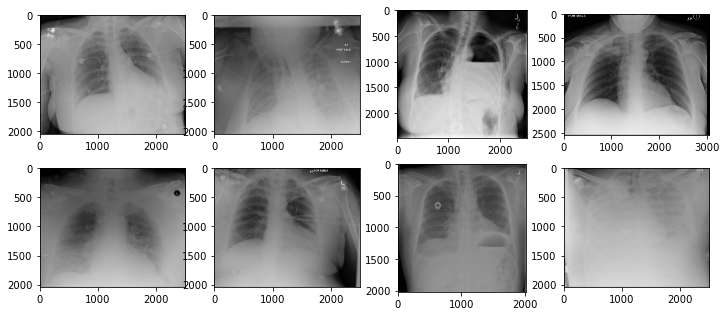

In [6]:
def visualize(number_images):
    plt.figure(figsize=(12,8))

    for num in range(number_images):
        
        plt.subplot(3,4,num+1)
        img = cv2.imread('../input/ranzcr-clip-catheter-line-classification/train/'+df.StudyInstanceUID.values[num] + '.jpg')
        plt.imshow(img)
        
    plt.show()
visualize(8)

In [7]:
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [9]:
model = model.to(device)

In [10]:
image = cv2.imread('../input/ranzcr-clip-catheter-line-classification/train/'+df.StudyInstanceUID.values[2] + '.jpg')


In [11]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from torchvision import transforms
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])


In [13]:
from PIL import Image

image = Image.open('../input/ranzcr-clip-catheter-line-classification/train/'+df.StudyInstanceUID.values[2] + '.jpg').convert("RGB")
image = transform(image)
print(image.shape)
batch = torch.unsqueeze(image,0).detach().cpu()
out = model(batch.cuda())

torch.Size([3, 224, 224])


In [14]:
out.shape

torch.Size([1, 1000])

In [15]:
from tqdm import tqdm

train_path = "../input/ranzcr-clip-catheter-line-classification/train/"
train_list = np.zeros((df.shape[0], 1000), dtype=np.float32)
model.eval()

for n, filename in tqdm(enumerate(df.StudyInstanceUID.values), total=df.shape[0]):
    with torch.no_grad():
        img =Image.open(train_path + filename + ".jpg").convert("RGB")
        image = transform(img)
        batch = torch.unsqueeze(image, 0).cuda()
        #batch = batch.to(device)
        train_list[n] = model(batch).detach().cpu()
    

100%|██████████| 30083/30083 [37:25<00:00, 13.40it/s] 


In [16]:
device

'cuda'

In [32]:
from tqdm import tqdm

test =pd.read_csv("../input/ranzcr-clip-catheter-line-classification/sample_submission.csv")
test_path = "../input/ranzcr-clip-catheter-line-classification/test/"
test_list = np.zeros((test.shape[0], 1000), dtype=np.float32)
model.eval()

for n, filename in tqdm(enumerate(test.StudyInstanceUID.values), total=test.shape[0]):
    with torch.no_grad():
        img =Image.open(test_path + filename + ".jpg").convert("RGB")
        image = transform(img)
        batch = torch.unsqueeze(image, 0).cuda()
        #batch = batch.to(device)
        test_list[n] = model(batch).detach().cpu()
    

100%|██████████| 3582/3582 [03:54<00:00, 15.25it/s]


In [18]:
targets = df[list(df.columns)[1:-1]]

In [19]:
valid_index = np.where((np.arange(train_list.shape[0])%20) == 0)[0]
train_index = np.where((np.arange(train_list.shape[0])%20) != 1)[0]

In [20]:
print(train_index.shape, valid_index.shape)

(28578,) (1505,)


In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
y_pred = np.zeros((len(valid_index), len(list(targets.columns[1:-1]))))

In [ ]:
targeted = df[list(df.columns)[1:-1]]
ytarget = targeted.values[valid_index]
ypred = np.zeros( (len(valid_index), len(targets)) )

targets = df.columns[1:-1]
print(targets)
for n, target in tqdm(enumerate(targets), total=len(targets)):
    
    xg = xgboost.XGBClassifier()
    print(rf, target)
    zg.fit( train_list[train_index], targeted.iloc[:,n].values[train_index] )
    test[target] = rf.predict_proba(test_list)[:,1]
    del xg
    gc.collect()

In [ ]:
test.head()

In [ ]:
test.to_csv("submission.csv")